## 0. Thực hiện kết nối với Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/0_GOS_TestCV/data_augment.zip"

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
   creating: data/validation/cat/
  inflating: data/validation/cat/10.jpg  
  inflating: data/validation/cat/10008.jpg  
  inflating: data/validation/cat/1001.jpg  
  inflating: data/validation/cat/10016.jpg  
  inflating: data/validation/cat/10021.jpg  
  inflating: data/validation/cat/10022.jpg  
  inflating: data/validation/cat/10023.jpg  
  inflating: data/validation/cat/10026.jpg  
  inflating: data/validation/cat/10027.jpg  
  inflating: data/validation/cat/10029.jpg  
  inflating: data/validation/cat/1003.jpg  
  inflating: data/validation/cat/10034.jpg  
  inflating: data/validation/cat/10036.jpg  
  inflating: data/validation/cat/10037.jpg  
  inflating: data/validation/cat/10040.jpg  
  inflating: data/validation/cat/10041.jpg  
  inflating: data/validation/cat/1005.jpg  
  inflating: data/validation/cat/10051.jpg  
  inflating: data/validation/cat/10054.jpg  
  inflating: data/validation/cat/10055.jpg  
  inflating: da

## 1. Import thư viện

In [3]:
import os
import cv2
import glob
import shutil
import random
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, optimizers, preprocessing
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
print("Now Dir:", os.getcwd())
print("Tensorflow:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

Now Dir: /content
Tensorflow: 2.19.0
Num GPUs Available:  1


## 2. Thiết lập đường dẫn và tham số cần thiết

In [5]:
# Define data paths and hyperparameters
BASE_DIR = "/content"
DATA_DIR = os.path.join(BASE_DIR, 'data')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALIDATION_DIR = os.path.join(DATA_DIR, 'validation')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Model parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 25
NUM_CLASSES = 2

# Class names
CLASS_NAMES = ['cat', 'dog']

print(f"Data directory: {DATA_DIR}")
print(f"Train directory: {TRAIN_DIR}")
print(f"Validation directory: {VALIDATION_DIR}")
print(f"Test directory: {TEST_DIR}")

# Check if directories exist
for dir_path in [TRAIN_DIR, VALIDATION_DIR, TEST_DIR]:
    if os.path.exists(dir_path):
        print(f"- {dir_path} exists")
    else:
        print(f"- {dir_path} does not exist")

Data directory: /content/data
Train directory: /content/data/train
Validation directory: /content/data/validation
Test directory: /content/data/test
- /content/data/train exists
- /content/data/validation exists
- /content/data/test exists


## 3. Load data

In [6]:
def count_images(directory):
    counts = {}
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(directory, class_name)
        if os.path.exists(class_dir):
            counts[class_name] = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        else:
            counts[class_name] = 0
    return counts

# Count images in each split
train_counts = count_images(TRAIN_DIR)
val_counts = count_images(VALIDATION_DIR)
test_counts = count_images(TEST_DIR)

print("Dataset Statistics:")
print("=" * 50)
print(f"Training set:")
for class_name, count in train_counts.items():
    print(f"  {class_name}: {count} images")
print(f"  Total: {sum(train_counts.values())} images")

print(f"\nValidation set:")
for class_name, count in val_counts.items():
    print(f"  {class_name}: {count} images")
print(f"  Total: {sum(val_counts.values())} images")

print(f"\nTest set:")
for class_name, count in test_counts.items():
    print(f"  {class_name}: {count} images")
print(f"  Total: {sum(test_counts.values())} images")

Dataset Statistics:
Training set:
  cat: 26247 images
  dog: 26247 images
  Total: 52494 images

Validation set:
  cat: 2499 images
  dog: 2499 images
  Total: 4998 images

Test set:
  cat: 1251 images
  dog: 1251 images
  Total: 2502 images


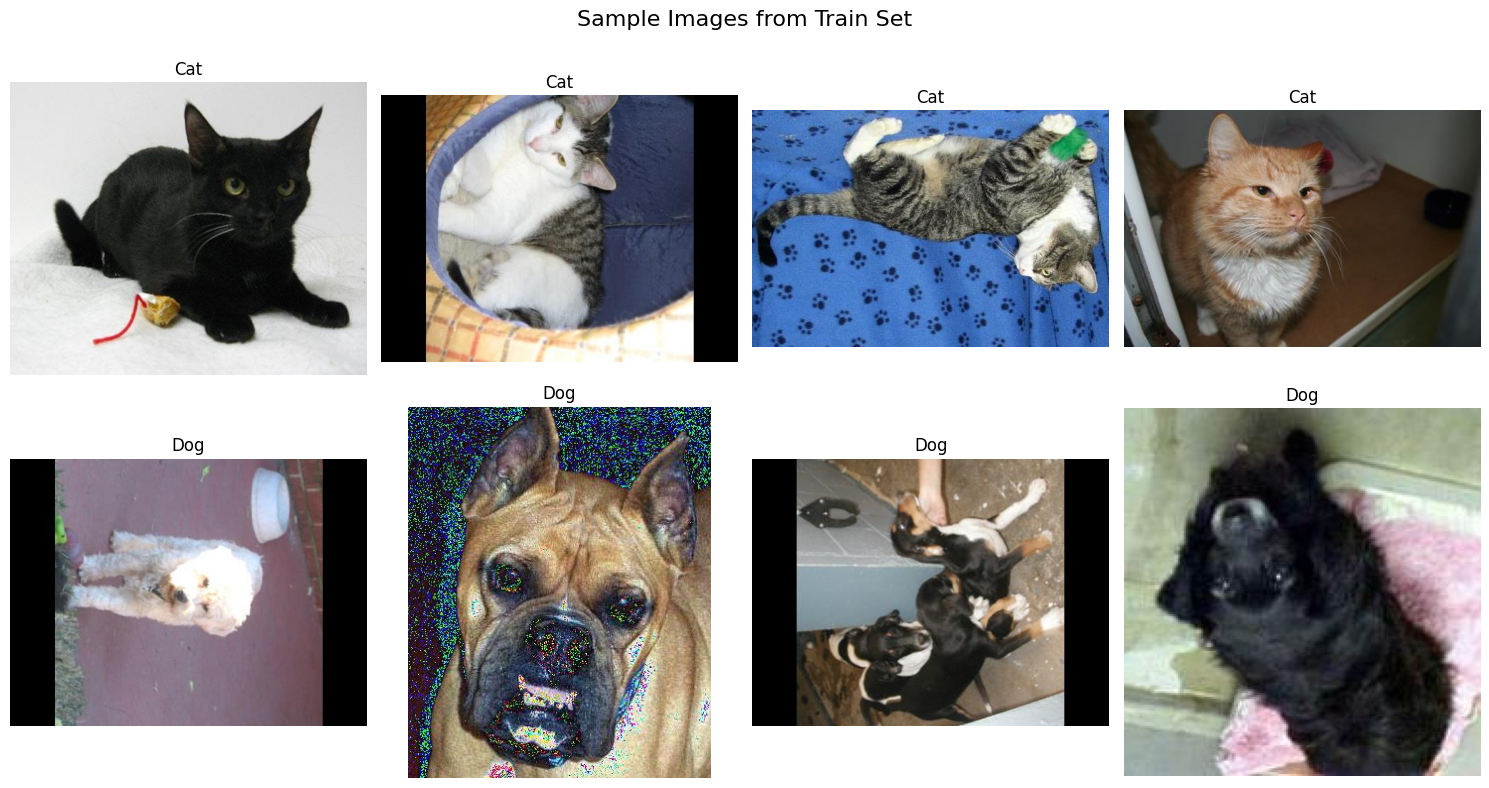

In [7]:
def display_sample_images(directory, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    fig.suptitle(f'Sample Images from {os.path.basename(directory).title()} Set', fontsize=16)

    for i, class_name in enumerate(CLASS_NAMES):
        class_dir = os.path.join(directory, class_name)
        if os.path.exists(class_dir):
            images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            sample_images = np.random.choice(images, min(4, len(images)), replace=False)

            for j, img_name in enumerate(sample_images):
                img_path = os.path.join(class_dir, img_name)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                axes[i, j].imshow(img)
                axes[i, j].set_title(f'{class_name.capitalize()}')
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Mở một vài hình trong tập train
display_sample_images(TRAIN_DIR)

## 4. Data Preprocessing và Augmentation

In [8]:
# Create data generators with preprocessing and augmentation
# Training data generator with augmentation
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)

# Validation and test data generators (only rescaling)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# train_datagen = ImageDataGenerator(rescale=1./255)
# validation_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',               # Binary classification (cat=0, dog=1)
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(f"Training batches: {len(train_generator)}")
print(f"Validation batches: {len(validation_generator)}")
print(f"Test batches: {len(test_generator)}")
print(f"Class indices: {train_generator.class_indices}")

Found 52494 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
Found 2502 images belonging to 2 classes.
Training batches: 1641
Validation batches: 157
Test batches: 79
Class indices: {'cat': 0, 'dog': 1}


## 5. Tạo kiến trúc CNN Model

In [9]:
def create_cnn_model():
    model = keras.Sequential([
        # Block 1
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.3),

        # Block 4
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.3),

        # Flatten + Dense
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Create the model
model = create_cnn_model()

# Display model architecture
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,682,497 (36.94 MB)

 Trainable params: 9,680,769 (36.93 MB)

 Non-trainable params: 1,728 (6.75 KB)

## 6. Train mô hình

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',                   # Adam optimizer
    loss='binary_crossentropy',         # Binary crossentropy for binary classification
    metrics=['accuracy']                # Track accuracy during training
)

# Define callbacks for better training
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Starting model training...")
print(f"Training for {EPOCHS} epochs with early stopping")
print("=" * 50)

Starting model training...
Training for 25 epochs with early stopping


In [11]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")
print("=" * 50)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.5872 - loss: 0.7784
Epoch 1: val_accuracy improved from -inf to 0.62145, saving model to best_model.h5


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 744s 445ms/step - accuracy: 0.5872 - loss: 0.7783 - val_accuracy: 0.6214 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 2/25
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.7111 - loss: 0.5567
Epoch 2: val_accuracy improved from 0.62145 to 0.74730, saving model to best_model.h5


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 692s 422ms/step - accuracy: 0.7111 - loss: 0.5567 - val_accuracy: 0.7473 - val_loss: 0.5694 - learning_rate: 0.0010
Epoch 3/25
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.7790 - loss: 0.4676
Epoch 3: val_accuracy did not improve from 0.74730
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 736s 418ms/step - accuracy: 0.7791 - loss: 0.4676 - val_accuracy: 0.6447 - val_loss: 0.8170 - learning_rate: 0.0010
Epoch 4/25
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.8176 - loss: 0.4020
Epoch 4: val_accuracy improved from 0.74730 to 0.90136, saving model to best_model.h5


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 700s 426ms/step - accuracy: 0.8176 - loss: 0.4020 - val_accuracy: 0.9014 - val_loss: 0.2631 - learning_rate: 0.0010
Epoch 5/25
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.8409 - loss: 0.3584
Epoch 5: val_accuracy did not improve from 0.90136
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 684s 417ms/step - accuracy: 0.8409 - loss: 0.3584 - val_accuracy: 0.8597 - val_loss: 0.3159 - learning_rate: 0.0010
Epoch 6/25
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8581 - loss: 0.3257
Epoch 6: val_accuracy did not improve from 0.90136
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 701s 427ms/step - accuracy: 0.8581 - loss: 0.3257 - val_accuracy: 0.8049 - val_loss: 0.4585 - learning_rate: 0.0010
Epoch 7/25
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8626 - loss: 0.3160
Epoch 7: val_accuracy did not improve from 0.90136
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 721s 415ms/step - accuracy: 0.8626 - loss: 0.3160 - val_accuracy: 0.8045 - val_loss: 0.4136 - learning_ra

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 689s 419ms/step - accuracy: 0.8806 - loss: 0.2761 - val_accuracy: 0.9300 - val_loss: 0.1671 - learning_rate: 2.0000e-04
Epoch 9/25
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8928 - loss: 0.2571
Epoch 9: val_accuracy did not improve from 0.92997
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 691s 421ms/step - accuracy: 0.8928 - loss: 0.2571 - val_accuracy: 0.9226 - val_loss: 0.1843 - learning_rate: 2.0000e-04
Epoch 10/25
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.8946 - loss: 0.2482
Epoch 10: val_accuracy improved from 0.92997 to 0.93657, saving model to best_model.h5


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 689s 420ms/step - accuracy: 0.8946 - loss: 0.2482 - val_accuracy: 0.9366 - val_loss: 0.1508 - learning_rate: 2.0000e-04
Epoch 11/25
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.8966 - loss: 0.2447
Epoch 11: val_accuracy improved from 0.93657 to 0.94318, saving model to best_model.h5


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 742s 420ms/step - accuracy: 0.8966 - loss: 0.2447 - val_accuracy: 0.9432 - val_loss: 0.1375 - learning_rate: 2.0000e-04
Epoch 12/25
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9006 - loss: 0.2397
Epoch 12: val_accuracy did not improve from 0.94318
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 748s 423ms/step - accuracy: 0.9006 - loss: 0.2397 - val_accuracy: 0.9326 - val_loss: 0.1572 - learning_rate: 2.0000e-04
Epoch 13/25
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9005 - loss: 0.2387
Epoch 13: val_accuracy did not improve from 0.94318
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 704s 429ms/step - accuracy: 0.9005 - loss: 0.2387 - val_accuracy: 0.9424 - val_loss: 0.1421 - learning_rate: 2.0000e-04
Epoch 14/25
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9042 - loss: 0.2304
Epoch 14: val_accuracy improved from 0.94318 to 0.94618, saving model to best_model.h5


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 697s 425ms/step - accuracy: 0.9042 - loss: 0.2304 - val_accuracy: 0.9462 - val_loss: 0.1291 - learning_rate: 2.0000e-04
Epoch 15/25
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9083 - loss: 0.2257
Epoch 15: val_accuracy did not improve from 0.94618
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 748s 429ms/step - accuracy: 0.9083 - loss: 0.2257 - val_accuracy: 0.9430 - val_loss: 0.1362 - learning_rate: 2.0000e-04
Epoch 16/25
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9042 - loss: 0.2311
Epoch 16: val_accuracy did not improve from 0.94618
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 693s 422ms/step - accuracy: 0.9042 - loss: 0.2311 - val_accuracy: 0.9398 - val_loss: 0.1430 - learning_rate: 2.0000e-04
Epoch 17/25
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9058 - loss: 0.2256
Epoch 17: val_accuracy did not improve from 0.94618
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 684s 417ms/step - accuracy: 0.9058 - loss: 0.2256 - val_accuracy: 0.9398 - val_loss: 0.

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 682s 415ms/step - accuracy: 0.9112 - loss: 0.2143 - val_accuracy: 0.9500 - val_loss: 0.1210 - learning_rate: 4.0000e-05
Epoch 19/25
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9112 - loss: 0.2126
Epoch 19: val_accuracy did not improve from 0.94998
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 748s 419ms/step - accuracy: 0.9112 - loss: 0.2126 - val_accuracy: 0.9458 - val_loss: 0.1262 - learning_rate: 4.0000e-05
Epoch 20/25
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9149 - loss: 0.2079
Epoch 20: val_accuracy did not improve from 0.94998
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 739s 418ms/step - accuracy: 0.9149 - loss: 0.2079 - val_accuracy: 0.9436 - val_loss: 0.1316 - learning_rate: 4.0000e-05
Epoch 21/25
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9122 - loss: 0.2100
Epoch 21: val_accuracy did not improve from 0.94998
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 689s 420ms/step - accuracy: 0.9122 - loss: 0.2100 - val_accuracy: 0.9482 - val_loss: 0.

## 7. Đánh giá hiệu suất mô hình

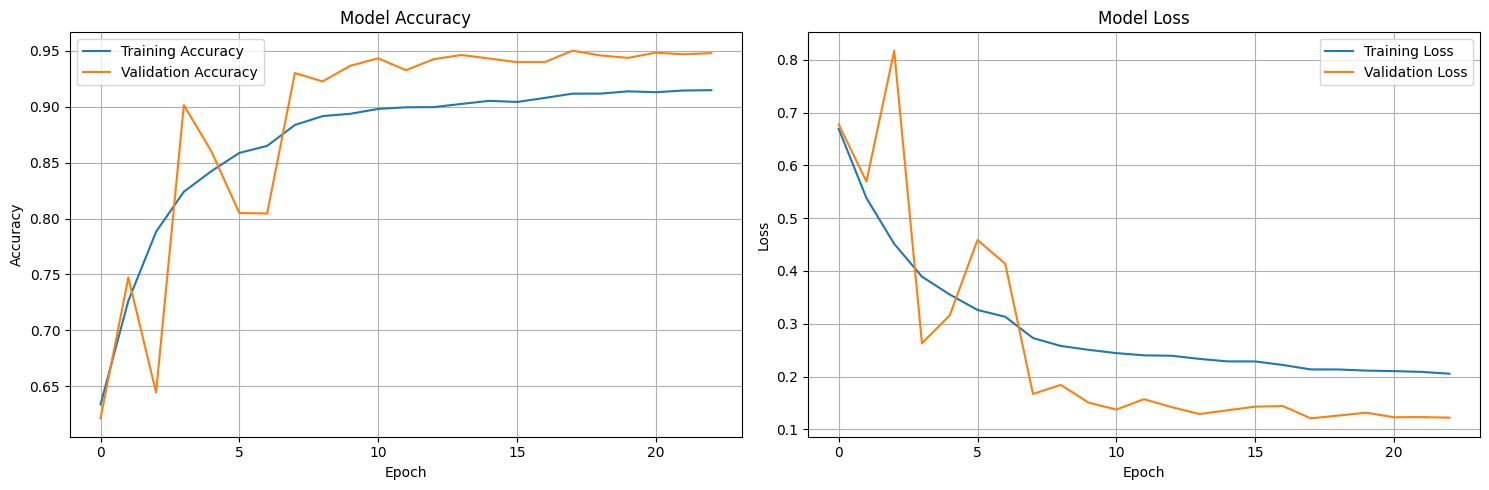

Final Training Accuracy: 0.9147
Final Validation Accuracy: 0.9478
Final Training Loss: 0.2054
Final Validation Loss: 0.1223


In [12]:
# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

# Get final training metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

Evaluating model on test set...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9684 - loss: 0.0913

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.9679 - loss: 0.0921
Test Accuracy: 0.9552
Test Loss: 0.1124
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step


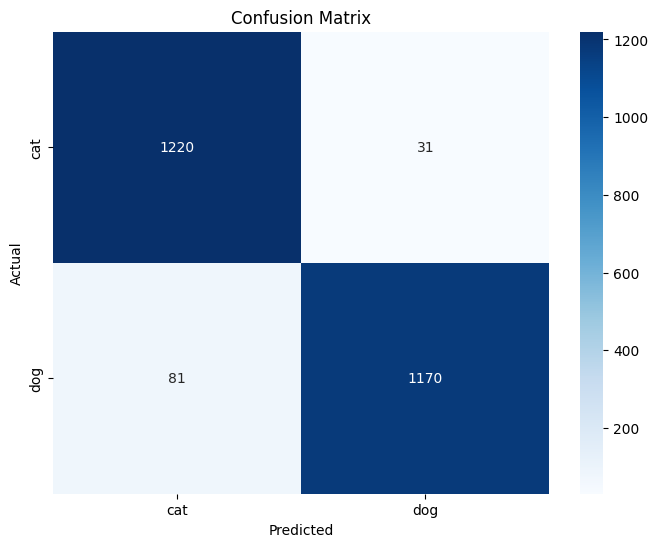


Classification Report:
              precision    recall  f1-score   support

         cat       0.94      0.98      0.96      1251
         dog       0.97      0.94      0.95      1251

    accuracy                           0.96      2502
   macro avg       0.96      0.96      0.96      2502
weighted avg       0.96      0.96      0.96      2502



In [13]:
# Evaluate on test set
print("Evaluating model on test set...")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions for confusion matrix
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = test_generator.classes

# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=CLASS_NAMES))

## 8. Dự đoán trên hình ảnh mới

Predictions on sample test images:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


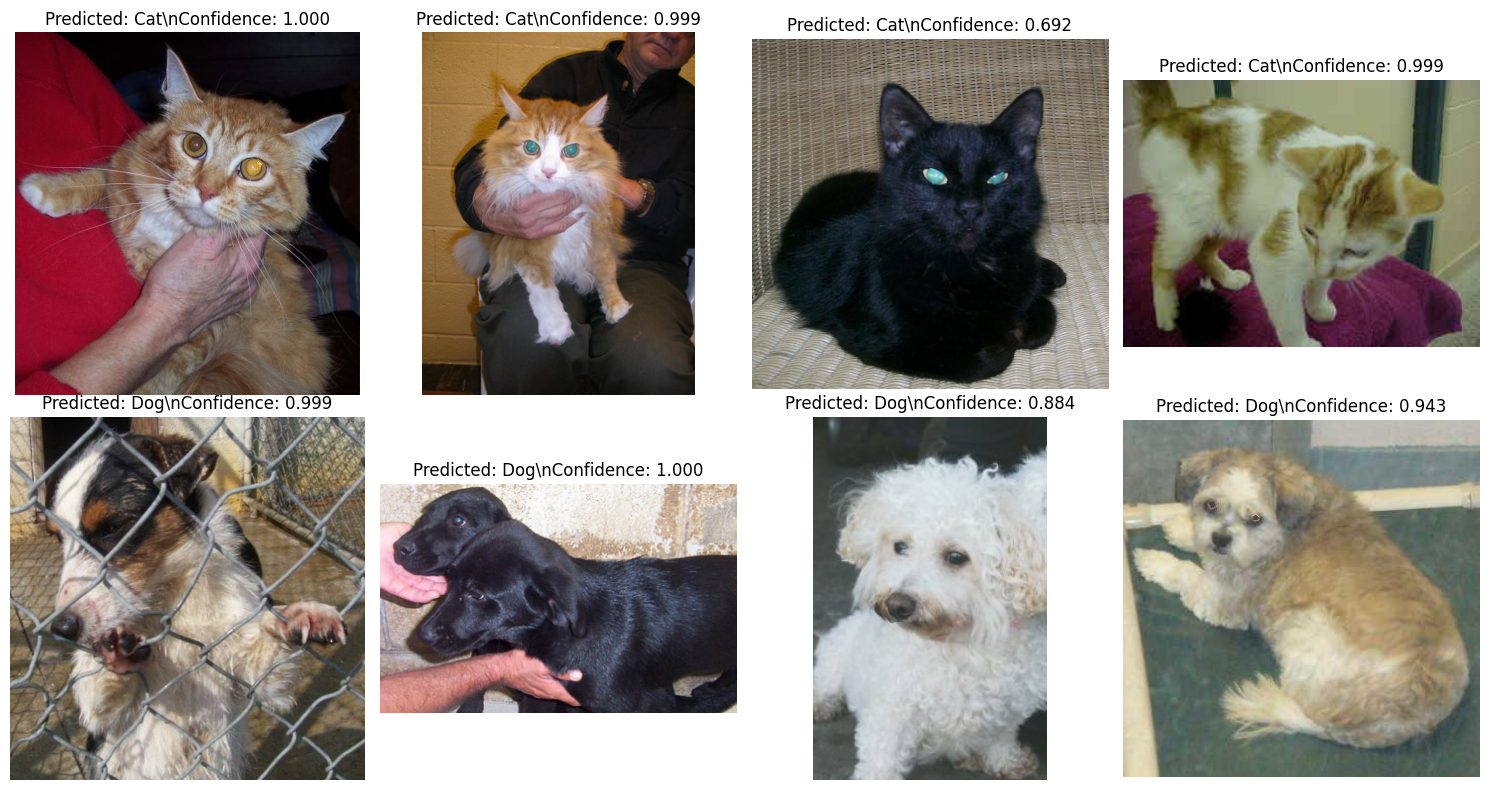

In [14]:
# Function to predict on a single image
def predict_image(image_path, model):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img_array = np.expand_dims(img_resized / 255.0, axis=0)

    # Make prediction
    prediction = model.predict(img_array)[0][0]

    # Convert to class name and confidence
    if prediction > 0.5:
        class_name = 'dog'
        confidence = prediction
    else:
        class_name = 'cat'
        confidence = 1 - prediction

    return class_name, confidence, img

# Function to display predictions
def display_predictions(image_paths, model, num_cols=4):
    num_images = len(image_paths)
    num_rows = (num_images + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
    if num_rows == 1:
        axes = axes.reshape(1, -1)

    for i, image_path in enumerate(image_paths):
        row = i // num_cols
        col = i % num_cols

        try:
            class_name, confidence, img = predict_image(image_path, model)

            axes[row, col].imshow(img)
            axes[row, col].set_title(f'Predicted: {class_name.capitalize()}\\nConfidence: {confidence:.3f}')
            axes[row, col].axis('off')
        except Exception as e:
            axes[row, col].text(0.5, 0.5, f'Error loading\\n{os.path.basename(image_path)}',
                               ha='center', va='center', transform=axes[row, col].transAxes)
            axes[row, col].axis('off')

    # Hide empty subplots
    for i in range(num_images, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Get some sample images from test set for prediction demonstration
sample_images = []
for class_name in CLASS_NAMES:
    class_dir = os.path.join(TEST_DIR, class_name)
    if os.path.exists(class_dir):
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        sample_images.extend([os.path.join(class_dir, img) for img in images[:4]])

# Display predictions on sample images
if sample_images:
    print("Predictions on sample test images:")
    display_predictions(sample_images[:8], model)
else:
    print("No test images found for prediction demonstration.")

## 9. Lưu mô hình

In [15]:
# Save the trained model
model_save_path = 'dog_cat_classifier_final.h5'
model.save(model_save_path)
print(f"Model saved as: {model_save_path}")

model_save_path = 'dog_cat_classifier_final_no_opt.h5'
model.save(model_save_path, include_optimizer=False)
print(f"Model saved as: {model_save_path}")

# Save model summary to text file
with open('model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\\n'))
print("Model summary saved to: model_summary.txt")

print("\\n" + "="*50)
print("Model Training and Evaluation Complete!")
print("="*50)
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Model files saved:")
print(f"  - {model_save_path}")
print(f"  - model_summary.txt")
print(f"  - best_model.h5 (best checkpoint)")
print("="*50)

Model saved as: dog_cat_classifier_final.h5
Model saved as: dog_cat_classifier_final_no_opt.h5


Model summary saved to: model_summary.txt
\n==================================================
Model Training and Evaluation Complete!
Final Test Accuracy: 0.9552
Model files saved:
  - dog_cat_classifier_final_no_opt.h5
  - model_summary.txt
  - best_model.h5 (best checkpoint)
